# Template code

We restructure here the code of Sharam to fit our need. The main difference is the delay in blocking over various variables, e.g. state and payer category. Rather, we are aiming for the following workflow:
- load the data from a pickle
- Optional: select a set of claims
- (pre, re)-process  the various features, in particular the categorical features
- If not already done, select a subset ( fixed state, fixed payer category, fixed CPT, amount paid =0,...) 
- model the subset
- possibly iterate to cover the whole dataset

The stategy is exploratory rather than systematic in its covering of the dataset. We want to compare various models and approaches on well behaved subsets of data. The code is structured to allow easy replacement of one option by another.


## Comments
- Strategy 1: keep N/A as long as possible to differentiate between n/a entries and 0 entries.
- Some  paid amounts are negative. That is likely an adjustement to some previous overepaid claims. To handle such paid amounts, it seems that we would need to keep track of the history of a particular individual. Statistical regularities may not be very usefual here. In absence of a time dependence between claims for a given individual, we are better off ignoring such claims. Our model is unlikely to be able to account for such adjustements given than the only information it uses is within the current claim.
- It is always good practice to scale the features and the labels if noly for numerical stability. But in addition if we work with the range [0,1], we may view any variables as a probability and use algorithms that are probability algorithms, e.g., logistic regression.
- That scaling of the numerical variables fits nicely with a cut-off for large entries.


## References
- Using categorical data in machine learning with python 

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing.label import LabelEncoder
#from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split 
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.tree.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

# Loading the data from file (Enter the current pickle)

In [16]:
filename = "2018-01-25df.joblib.pkl"
df = joblib.load(filename)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5752317 entries, 0 to 5752316
Data columns (total 54 columns):
IDentity         int64
CreateDTS        datetime64[ns]
UpdateDTS        datetime64[ns]
CPT              object
Mod1             object
Mod2             object
Mod3             object
Mod4             object
ICD1             object
ICD2             object
ICD3             object
ICD4             object
ChargeAmount     float64
ClaimStatus      object
PayerCategory    object
PayerState       object
Specialty        object
Sex              object
FacilityType     object
InsuranceType    object
DOSFrom          object
DOSTo            object
SubmitDate       object
PaidAmount       float64
R1               object
R2               object
R3               object
R4               object
R5               object
R6               object
R7               int64
R8               int64
R9               int64
R10              int64
AdjCode1         object
AdjAmt1          float64
AdjCode2 

# Pick features and labels

In [54]:
column_names = ['IDentity','CreateDTS','UpdateDTS','CPT','Mod1', 'Mod2','Mod3', 'Mod4', 'ICD1', 'ICD2', 'ICD3', 'ICD4', 
                'ChargeAmount', 'ClaimStatus', 'PayerCategory', 'PayerState', 'Specialty', 'Sex', 'FacilityType', 'InsuranceType',
                'DOSFrom', 'DOSTo','SubmitDate', 'PaidAmount', 'R1', 'R2', 'R3', 'R4', 'R5','R6','R7','R8','R9', 'R10',
                'AdjCode1', 'AdjAmt1', 'AdjCode2', 'AdjAmt2', 'AdjCode3', 'AdjAmt3', 'AdjCode4', 'AdjAmt4', 'AdjCode5', 'AdjAmt5',
                'AdjCode6', 'AdjAmt6', 'AdjCode7', 'AdjAmt7', 'AdjCode8', 'AdjAmt8', 'AdjCode9', 'AdjAmt9', 'AdjCode10', 'AdjAmt10']

cat_features = ['CPT','Mod1', 'Mod2','Mod3', 'Mod4', 'ICD1', 'ICD2', 'ICD3', 'ICD4', 
                   'PayerCategory','PayerState','Specialty', 'Sex', 'InsuranceType', 'IDentity']
cat_features.append('FacilityType')  ## JLL: Shahram is adding that feature later. 
cat_features.remove('IDentity') ## JLL: Too many levels, no relation between the levels. Handle later.
numeric_features = ['ChargeAmount']                
 
    
cat_labels = ['ClaimStatus','R1', 'R2', 'R3', 'R4',
                'AdjCode1', 'AdjCode2', 'AdjCode3', 'AdjCode4', 'AdjCode5']
numeric_labels   = ['PaidAmount','AdjAmt1', 'AdjAmt2', 'AdjAmt3', 'AdjAmt4', 'AdjAmt5']

In [5]:
MIN_DATA_THRESHOLD = 100
TEST_FRACTION = 0.1
cleanup_columns =['PayerState', 'CPT']
NUMERIC = 'Numeric'
FACILITY_TYPE = 'FacilityType'
PAYER_STATE = 'PayerState'
PAYER_CAT = 'PayerCategory'
state_value_count = df['PayerState'].value_counts()
payer_cat_value_count = df['PayerCategory'].value_counts()

# X and y - Choose y here, Optionally choose rows here.
Selecting the columns we want to work with and transforming the Panda dataframe to a numpy array.
We choose the dependent variables here, and we may want to choose the subset(s) of data we plan to model.

In [119]:
X_df = df[numeric_features + cat_features]
y_df = df['PaidAmount']


In [56]:
type(X), X.shape, type(X[0,1])

(numpy.ndarray, (5752317, 16), str)

## Exploring the data

In [61]:
y.shape, type(y), y.dtype

((5752317,), numpy.ndarray, dtype('float64'))

In [63]:
len(y[y<0])


4659

(array([  6.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   3.00000000e+01,
          4.61300000e+03]),
 array([ -9.00000000e+03,  -8.10001300e+03,  -7.20002600e+03,
         -6.30003900e+03,  -5.40005200e+03,  -4.50006500e+03,
         -3.60007800e+03,  -2.70009100e+03,  -1.80010400e+03,
         -9.00117000e+02,  -1.30000000e-01]),
 <a list of 10 Patch objects>)

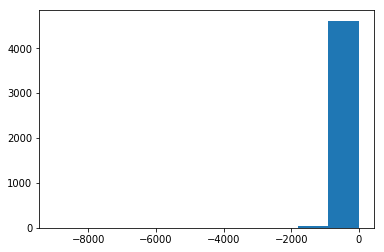

In [65]:
plt.hist(y[y<0])

(array([  5.42406500e+06,   2.44840000e+05,   3.90740000e+04,
          1.55750000e+04,   5.23100000e+03,   4.20500000e+03,
          2.37800000e+03,   1.87700000e+03,   1.37200000e+03,
          9.88000000e+02,   8.31000000e+02,   6.44000000e+02,
          9.16000000e+02,   3.04000000e+02,   6.48000000e+02,
          1.14100000e+03,   3.96000000e+02,   2.10000000e+02,
          2.46000000e+02,   2.27000000e+02,   2.12000000e+02,
          8.40000000e+01,   9.40000000e+01,   1.33000000e+02,
          8.90000000e+01,   5.80000000e+01,   8.10000000e+01,
          9.50000000e+01,   9.50000000e+01,   7.90000000e+01,
          1.50000000e+02,   2.60000000e+01,   5.70000000e+01,
          5.80000000e+01,   4.30000000e+01,   4.50000000e+01,
          2.20000000e+01,   1.30000000e+01,   5.10000000e+01,
          3.00000000e+01,   2.90000000e+01,   3.00000000e+01,
          4.30000000e+01,   2.40000000e+01,   2.00000000e+01,
          1.50000000e+01,   8.00000000e+00,   7.00000000e+00,
        

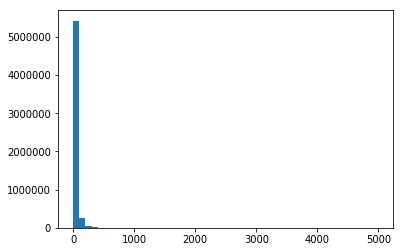

In [74]:
msk = (0 <= y) & (y < 5000)
plt.hist(y[msk],bins=50)

In [78]:
msk = (0 <= y) & (y < 0.1)
len(y[msk])

3956165

In [79]:
df['CPT'].value_counts()

99213    494528
99214    438680
97110    148003
99232    140180
90837    114960
97140    113588
36415     93399
98941     78362
99212     71689
99203     66864
99233     64975
99215     64930
99204     64499
97112     60183
90834     56890
99309     49092
81002     48953
97530     47274
96372     42271
99308     42099
90833     41869
90460     40305
11721     39111
99223     34095
G8427     32533
98940     31018
87880     30755
92507     28560
T2016     26486
99396     25857
          ...  
5015F         1
50820         1
G9008         1
97260         1
81321         1
63102         1
26185         1
72198         1
99707         1
82085         1
00100         1
85576         1
V2410         1
30460         1
49582         1
D5860         1
A4630         1
99456         1
21199         1
22511         1
1044M         1
51800         1
58958         1
J2597         1
C1713         1
A5503         1
G6032         1
J7604         1
G8579         1
77085         1
Name: CPT, Length: 6996,

In [84]:
x0=df[df['CPT']== '99214']['ChargeAmount']
y0=df[df['CPT']== '99214']['PaidAmount']

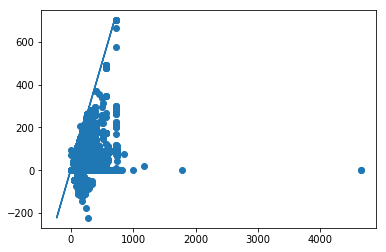

In [95]:
plt.scatter(x0,y0)
plt.plot(y0,y0)

In [ ]:
# Needs the histogram of PaidAmount at fixed CPT

## Train and test split

In [132]:
# Option 1
# Splitting dataframes
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, 
                                                    test_size=test_size, 
                                                    random_state=0)

In [ ]:
# Option 2
# Splitting arrays
indices = np.arange(n_samples)
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    data, labels, indices, test_size=0.2)

In [176]:
# Option 3
# manual Splitting 
test_size = 0.2
threshold = 1 - test_size
mask_split = np.random.rand(len(df)) < threshold

# train = df[mask_split]

# test = df[~mask_split]

# Primitive baseline models
PaidAmount: Guess $0.
PaidAmount: Block over a few variables ( State,.., and/or CPT). Use average paid amounts for suitable claims, i.e. not outright outliers. May require a minimum of claims per block and cut off 5% or 10% at the top, depending on the distribution of the paidamount.

ClaimStatue: 2% rejected. Guess all accepted. Maybe check in term of CPT. 

In [122]:
state = 'GA'
payercategory = 'Commercial'
mask_train = (X_train['PayerState']==state) & (X_train['PayerCategory']== payercategory)
mask_test = (X_test['PayerState']==state) & (X_test['PayerCategory']== payercategory)

y_train_m = y_train[mask_train]
y_test_m = y_test[mask_test]

In [123]:
y_train_m.shape

(131928,)

In [128]:
y_mean = y_train_m.mean()
y_pred_m = np.ones(len(y_test_m))*y_mean
loss = mean_squared_error(y_test_m, y_pred_m)
r2 = r2_score(y_test_m, y_pred_m)

# y_mean
print('y_mean: %.2f' % y_mean)

# The mean squared error
print("Root mean squared error: %.2f" % loss**(1/2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2)

y_mean: 25.92
Root mean squared error: 240.69
Variance score: -0.00


(array([  2.92250000e+04,   3.87900000e+03,   7.90000000e+01,
          3.10000000e+01,   9.00000000e+00,   8.00000000e+00,
          8.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

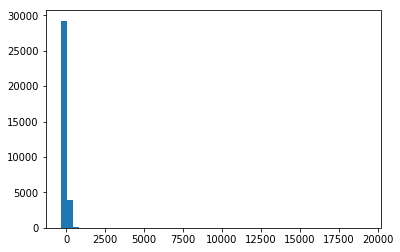

In [129]:
plt.hist(y_test,bins=50)

In [136]:
mask_test.shape,y_test.shape

((4601853,), (1150464,))

In [156]:
cpt = '99214'

mask_train = X_train['CPT']==cpt
mask_test =  X_test['CPT']==cpt

y_train_m = y_train[mask_train]
y_test_m = y_test[mask_test]

In [157]:
mask_train.value_counts()

False    4250707
True      351146
Name: CPT, dtype: int64

In [158]:
y_mean = y_train_m.mean()
y_pred_m = np.ones(len(y_test_m))*y_mean
loss = mean_squared_error(y_test_m, y_pred_m)
r2 = r2_score(y_test_m, y_pred_m)

# y_mean
print('y_mean: %.2f' % y_mean)

# The mean squared error
print("Root mean squared error: %.2f" % loss**(1/2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2)

y_mean: 29.65
Root mean squared error: 42.79
Variance score: -0.00


(array([  1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   4.10000000e+01,   4.00000000e+00,
          2.00000000e+00,   1.20000000e+01,   6.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   5.55380000e+04,
          6.97000000e+02,   7.84000000e+02,   1.13500000e+03,
          2.05500000e+03,   4.44700000e+03,   1.10820000e+04,
          6.55900000e+03,   2.56200000e+03,   1.14300000e+03,
          4.07000000e+02,   2.08000000e+02,   2.30000000e+02,
          8.20000000e+01,   1.23000000e+02,   5.80000000e+01,
          1.36000000e+02,   4.90000000e+01,   6.40000000e+01,
          2.30000000e+01,   4.00000000e+01,   2.80000000e+01,
          2.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

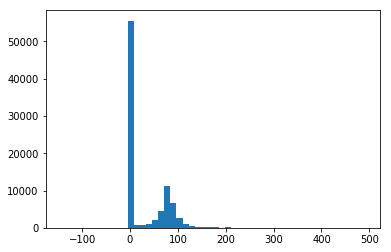

In [163]:
plt.hist(y_test_m,bins=50)

(0, 300)

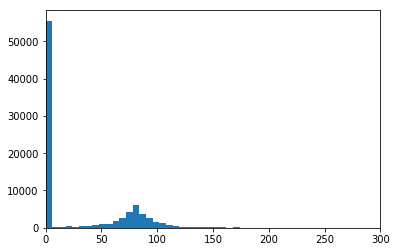

In [165]:
mask = (y_test_m >= 0)& (y_test_m <= 300)
plt.hist(y_test_m[mask],bins=50)
plt.xlim((0,300))

# Preprocessing the categorical features

### Label Encoding

In [184]:
# The columns to encode
columns_enc = cat_features

encoders = {} ##  a dictionary {col:enc,...}

for col in columns_enc:
    print('Encoding column ', col)
    encoder = preprocessing.LabelEncoder()
    encoder.fit(df[col].astype(str))
    encoders[col]= encoder  ## storing the encoders

   

In [186]:
encoders

{'CPT': LabelEncoder(),
 'FacilityType': LabelEncoder(),
 'ICD1': LabelEncoder(),
 'ICD2': LabelEncoder(),
 'ICD3': LabelEncoder(),
 'ICD4': LabelEncoder(),
 'InsuranceType': LabelEncoder(),
 'Mod1': LabelEncoder(),
 'Mod2': LabelEncoder(),
 'Mod3': LabelEncoder(),
 'Mod4': LabelEncoder(),
 'PayerCategory': LabelEncoder(),
 'PayerState': LabelEncoder(),
 'Sex': LabelEncoder(),
 'Specialty': LabelEncoder()}

In [170]:
# Another option

X_train_numb = X_train.values
X_test_numb = X_test.values
#y = y_df.values

X_ordinal = X  ## an alias. Do we need an explicit copy here?

encoders = []

for i in range(X_train_numb.shape[1]):
    print('Encoding column ', i)
    if i < len(numeric_features):
        continue 
    X_train_numb[:, i] =  X_train_numb[:, i].astype(str)
    X_test_numb[:, i] =  X_test_numb[:, i].astype(str)## we have int 0 and str entries.
    encoder = preprocessing.LabelEncoder()
    encoder.fit(np.concatenate([X_train_numb[:,i],X_test_numb[:,i]]))
    encoders.append(encoder)  ## storing the encoders
    X_train_numb[:, i] = encoder.transform(X_train_numb[:, i])
    X_test_numb[:, i] = encoder.transform(X_test_numb[:, i])
    # we get a problem: ValueError: y contains new labels:
    # Could try to add teh attribute handle_unknown='ignore'. Works for one hot encoding.
    # Or use the fullset to generate the encoding as a temporary measure.
    # Ideally, we should work from a full catalog of levels.
   

Encoding column  0
Encoding column  1
Encoding column  2
Encoding column  3
Encoding column  4
Encoding column  5
Encoding column  6
Encoding column  7
Encoding column  8
Encoding column  9
Encoding column  10
Encoding column  11
Encoding column  12
Encoding column  13
Encoding column  14
Encoding column  15


## Choosing and preparing the subsets of data

In [227]:
cpt = '99214'

mask_sub = df['CPT']== cpt


# Pick the rows of interest.
# X_df picks the columsn of interest from df
# and the mask(s) picks the relevant rows.
X_train = X_df[mask_split & mask_sub].copy()
X_test = X_df[~mask_split & mask_sub].copy()
y_train = y_df[mask_split & mask_sub].copy()
y_test = y_df[~mask_split & mask_sub].copy()

In [229]:
X_train.head()

,ChargeAmount,CPT,Mod1,Mod2,Mod3,Mod4,ICD1,ICD2,ICD3,ICD4,PayerCategory,PayerState,Specialty,Sex,InsuranceType,FacilityType
2,225.0,99214,0,0,0,0,I10,G40909,K210,G5600,BCBS,MN,0,Female,PrimaryProfessional,Office
3,225.0,99214,0,0,0,0,I10,K210,0,0,Medicare RR,GA,0,Female,PrimaryProfessional,Office
4,225.0,99214,0,0,0,0,I2510,I10,E782,E119,Medicare RR,GA,0,Male,PrimaryProfessional,Office
8,225.0,99214,25,0,0,0,I10,R002,0,0,Commercial,KY,207R00000X,Male,PrimaryProfessional,Office
10,225.0,99214,0,0,0,0,R5382,D500,0,0,Commercial,KY,207R00000X,Female,PrimaryProfessional,Office


In [230]:
# Encode the categorical features
for col in columns_enc:
    print ("processing column:",col)
    encoder = encoders[col]
    X_train.loc[:,col] = encoder.transform(X_train.loc[:,col].astype(str).values)
    print ("done")
    X_test[col] = encoder.transform(X_test[col].astype(str).values)
    

processing column: CPT


/etc/anaconda/envs/python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


done


/etc/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


processing column: Mod1
done
processing column: Mod2
done
processing column: Mod3
done
processing column: Mod4
done
processing column: ICD1
done
processing column: ICD2
done
processing column: ICD3
done
processing column: ICD4
done
processing column: PayerCategory
done
processing column: PayerState
done
processing column: Specialty
done
processing column: Sex
done
processing column: InsuranceType
done
processing column: FacilityType
done


## Linear regression

In [173]:
cpt = '99214'

mask_train = X_train_numb['CPT']==cpt
mask_test =  X_test_numb['CPT']==cpt

X_train_numb_m = X_train_numb[mask_train]
X_test_numb_m = X_test_numb[mask_train]
y_train_m = y_train[mask_train]
y_test_m = y_test[mask_test]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [237]:
linregr = linear_model.LinearRegression()
linregr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [238]:
# The coefficients
print('Coefficients: \n', linregr.coef_)

Coefficients: 
 [  6.10188559e-02  -9.78373198e-14  -1.50999504e-02   1.37308552e-02
  -3.23821611e-01  -7.14706072e-16  -1.56979234e-04   2.84184477e-05
   7.67334105e-05   1.84061520e-04   1.29048260e+00   1.08381525e-01
  -8.14364681e-02  -4.38233410e-01   4.28376140e+00   1.48382120e-01]


In [239]:
y_pred = linregr.predict(X_test)

In [241]:
loss = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# The mean squared error
print("Root mean squared error: %.2f" % loss**(1/2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2)

Root mean squared error: 42.49
Variance score: 0.02


## Decision tree regression

In [253]:
model = DecisionTreeRegressor(max_depth= 5) 

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)


In [254]:
score, msqr, r2

(0.12896435123799443, 40.096367365950968, 0.12896435123799443)

In [261]:
model = DecisionTreeRegressor(max_depth= 10) 

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

In [262]:
score, msqr, r2

(0.20922278062880162, 38.204466408218053, 0.20922278062880162)

In [265]:
#Overfitting for maxdepth around 20, 16 is still fine.
model = DecisionTreeRegressor(max_depth= 20) 

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

In [266]:
score, msqr, r2

(0.15913644399426508, 39.395791341916357, 0.15913644399426508)

## Random Forest regression¶

In [270]:
model = RandomForestRegressor(max_depth=8)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.18581674337355703, 38.765746105827752, 0.18581674337355703)

In [271]:
model = RandomForestRegressor(max_depth=4)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.1107902952430093, 40.512510862015411, 0.11079029524300932)

In [272]:
model = RandomForestRegressor(max_depth=12)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.26622949471425361, 36.801641378803247, 0.26622949471425361)

In [273]:
model = RandomForestRegressor(max_depth=16)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.31080027985863135, 35.666427417367892, 0.31080027985863135)

In [274]:
model = RandomForestRegressor(max_depth=20)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.32105052529429279, 35.400206210594995, 0.32105052529429279)

In [275]:
# Left to its own device, the model is overfitting.
model = RandomForestRegressor()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

score =  model.score(X_test, y_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

(0.25845758483778591, 36.996024815047477, 0.25845758483778591)

## Boosted trees
#https://xgboost.readthedocs.io/en/latest/model.html

## One Hot Encoding

In [276]:
X_ohe = pd.get_dummies(data=X_df[mask_sub], columns=cat_features)

In [277]:
X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438680 entries, 2 to 5752315
Columns: 30517 entries, ChargeAmount to FacilityType_Urgent Care Facility
dtypes: float64(1), uint8(30516)
memory usage: 12.5 GB


In [278]:
test_size = 0.2
threshold = 1 - test_size
mask_split = np.random.rand(len(X_ohe)) < threshold

In [283]:
X_train = X_ohe[mask_split ]
X_test = X_ohe[~mask_split ]
y_train = X_ohe[mask_split ]
y_test = X_ohe[~mask_split ]

NameError: name 'y_ohe' is not defined

In [282]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351066 entries, 2 to 5752315
Columns: 30517 entries, ChargeAmount to FacilityType_Urgent Care Facility
dtypes: float64(1), uint8(30516)
memory usage: 10.0 GB


## Linear regression

In [280]:
model = linear_model.LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
msqr = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

score, msqr, r2

MemoryError: 

In [ ]:

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train) ##  use both train and test here optimally
X_train = enc.transform(X_train)
X_test_one_hot = enc.transform(X_test_ordinal)
l.fit(X_train_one_hot,y_train)
y_pred = l.predict_proba(X_test_one_hot)
print(log_loss(y_test,y_pred))
r.fit(X_train_one_hot,y_train)
y_pred = r.predict_proba(X_test_one_hot)
print(log_loss(y_test,y_pred))
print(X_train_one_hot.shape)

In [113]:
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[:,1:])
X_one_hot = encoder.transform(X_ordinal[:,1:])

# Classically, the encoder is fitted using X_train_ordinal and then we transform X_train and X_test.
# What happens if some category levels of X_test do not appear in X_train?
# Is that what handle_unknown handles?
# We prefer so far to use the whole X to fit the encoder.

In [115]:
X_one_hot.shape

(5752317, 70959)

## Fitting

# Helper Code

In [ ]:
class DataFrameSelectorAsCategory(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].astype('category').values
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].astype('|S').values

class DataFrameNumericCleanerSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return np.nan_to_num(X[self.attribute_names].values)
    
def get_label_encoded_category_data(selector, df):
    encoder = LabelEncoder()
    category_clean = selector.fit_transform(df)
    category_encoded= encoder.fit_transform(category_clean)
    return category_encoded

# JLL: Commented version 
def prepare_data(df):

    #now create a dataframe for each state before proceeding

    #cleanup and scale the numerical data 
    num_feature_pipeline = Pipeline([
        ('selector', DataFrameNumericCleanerSelector(DF_numeric_features)),
        ])
    num_label_pipeline = Pipeline([
        ('selector', DataFrameNumericCleanerSelector(DF_numeric_labels)),
        ])
    claims_labels_dict = {}
    claims_numeric_labels = {}
    claims_feature_encoded = {}
    claims_data_encoded = {}

    for payer_cat in payer_cat_value_count.index:
        cat_df = df[df[PAYER_CAT] == payer_cat]
        # cat_df picks the rows of dataframe df with PAYER_CAT entry payer_cat
        claims_labels_dict[payer_cat] = {}
        claims_numeric_labels[payer_cat] = {}
        claims_feature_encoded[payer_cat] = {}
        claims_data_encoded[payer_cat] = {}
        for state in state_value_count.index:
            if state != 0:
                print(state)

                state_df = cat_df[cat_df[PAYER_STATE] == state]  
                # Likewise state_df picks the rows of dataframe df with 
                # suitable PAYER_CAT entry and PAYER_STATE entry. Double grouping/indexing.
                # That is the dataframe we want to work with
                if state_df.shape[0] > 1000 :
                # Require at least 1000 rows    
    

                    claims_feature_encoded[payer_cat][state] = num_feature_pipeline.fit_transform(state_df)
                    # Returns an array of values ( as many as df has rows)
                    # The values are of the type array([ 33.]). The content 33.
                    # is df[payer_cat][state] entry. df index is lost though.
                    claims_numeric_labels[payer_cat][state] = num_label_pipeline.fit_transform(state_df)
                    # Returns an array of values ( as many as df has rows)
                    # The values are of the type array([  71.26,   20.  ,  133.74,    0.  ,    0.  ,    0.  ])
                    # The contents are the state_df entries for  DF_numeric_labels which is
                    # ['PaidAmount', 'AdjAmt1', 'AdjAmt2', 'AdjAmt3', 'AdjAmt4', 'AdjAmt5']
                    
                    #create a dictionary so that the data can be grouped based on various labels
                    claims_labels_dict[payer_cat][state] = {}
                    claims_labels_dict[payer_cat][state][NUMERIC] = claims_numeric_labels[payer_cat][state]
                    #one hot encode the categorial labels and features
                    for category in DF_cat_labels:
                        print(category)
                        selector = DataFrameSelector(category)
                        claims_labels_dict[payer_cat][state][category] = get_label_encoded_category_data(selector, state_df)
                        # we get one array of numerized values via LabelEncoder per category
                        # The labels columns are kept separate; they all have a key
                    for category in DF_cat_features:
                        print(category)
                        selector = DataFrameSelector(category)
                        temp = get_label_encoded_category_data(selector,state_df).reshape(-1,1)
                        # we now have an array as for DF_cat_labels, we reshape it and put them all together in one big matrix X. 
                        claims_feature_encoded[payer_cat][state] = np.hstack([claims_feature_encoded[payer_cat][state],temp])
# The keys of the dictionary claims_labels_dict[payer_cat][state] are
# 'AdjCode2', 'R4', 'Numeric', 'AdjCode4', 'R1', 'R2', 'AdjCode1', 'R3', 'AdjCode3', 'ClaimStatus', 'AdjCode5'
# and the entries are all arrays of length the number of rows of the corresponding df.
                    selector = DataFrameSelectorAsCategory(FACILITY_TYPE)
                    temp = np.asarray(get_label_encoded_category_data(selector,state_df)).reshape(-1,1)
                    claims_data_encoded[payer_cat][state] = np.hstack([claims_feature_encoded[payer_cat][state],temp])
    return claims_data_encoded, claims_labels_dict

# claims_data_encoded[payer_cat][state] is an array of shape (number of df rows, 17).
# The numbers of columns 17 is the number of features we have. len(DF_cat_features)= 15 + 1 numeric feature
# 'CPT','Mod1', 'Mod2', 'Mod3', 'Mod4', 'ICD1', 'ICD2', 'ICD3', 'ICD4', 'PayerCategory', 'PayerState', 'Specialty', 'Sex', 'InsuranceType', 'IDentity'
# The last column of claims_data_encoded is  FACILITY_TYPE and added at the end.

def prepare_train_label_data(claims_data_encoded, claims_labels_dict):
    train_set = {}
    test_set = {}
    y_train = {}
    y_test = {}
    dict_labels = DF_cat_labels
    dict_labels.append(NUMERIC)
    for payer_cat in payer_cat_value_count.index:
        train_set[payer_cat] = {}
        test_set[payer_cat] = {}
        y_train[payer_cat] = {}
        y_test[payer_cat] = {}
        for state in state_value_count.index:
            # #############################################################################
            # create test features and labels
            if state != 0:
                train_set[payer_cat][state] = {}
                test_set[payer_cat][state] = {}
                y_train[payer_cat][state] = {}
                y_test[payer_cat][state] = {}
                for label in dict_labels: 
                    print(label)
                    try:
                        train_set[payer_cat][state][label], test_set[payer_cat][state][label],y_train[payer_cat][state][label], y_test[payer_cat][state][label] = train_test_split(claims_data_encoded[payer_cat][state],claims_labels_dict[payer_cat][state][label], test_size=TEST_FRACTION, random_state=42)
                        print(payer_cat, state, label, "train:", train_set[payer_cat][state][label].shape, "test:", test_set[payer_cat][state][label].shape,"train_label:", y_train[payer_cat][state][label].shape, "test_label:", y_test[payer_cat][state][label].shape )
                    except :
                        print("There must be no data for payer category, state, and label combo :", payer_cat, state, label)

    return train_set, test_set, y_train, y_test

# Returns a dictionary of quadruplets, keyed by payer_cat, state, 
# AND labels from DF_cat_labels+'NUMERIC'. 
# Each label gets the same X_train and X_test at given payer_cat and state.

def evaluate(model, train_set, y_train, test_set, y_test, label, data_fraction):
    
    models = {} 
    precision = {}
    recall = {}
    y_predict_hat = {} 
    i = 0
    if (data_fraction <= 0 or data_fraction > 1):
        data_fraction = 1
        
    for payer_cat in payer_cat_value_count.index:
        models[payer_cat] = {}
        precision[payer_cat] = {}
        recall[payer_cat] = {}
        y_predict_hat[payer_cat] = {}

        for state in state_value_count.index:
            if state != 0:
                try:
                    train_data_set, train_label_set, test_data_set, test_label_set = get_shaped_data(train_set[payer_cat][state], y_train[payer_cat][state], test_set[payer_cat][state], y_test[payer_cat][state], label, data_fraction)
                    startTime = time.time()
                    precision[payer_cat][state] = []
                    models[payer_cat][state] = []
                    recall[payer_cat][state] = []
                    y_predict_hat[payer_cat][state] = []
                    model.fit(train_data_set, train_label_set)
                    models[payer_cat][state] = model
                    y_predict_hat[payer_cat][state] = model.predict(test_data_set)
                    # Check on confusion_matrix
                    confmat = confusion_matrix(test_label_set,y_predict_hat[payer_cat][state])
                    print(str(confmat))
                    precision[payer_cat][state] = precision_score(test_label_set,y_predict_hat[payer_cat][state])
                    recall[payer_cat][state] = recall_score(test_label_set,y_predict_hat[payer_cat][state])
                    endTime = time.time()
                    i = i + 1
                    print(payer_cat, state, 'precision:', precision[payer_cat][state], 'recall:', recall[payer_cat][state], 'time:', endTime - startTime, 'Dataset Shape:', train_data_set.shape)
                    #value, counts = np.unique(y_predict_hat[payer_cat][state], return_counts= True)
                    #value1, counts1 = np.unique(test_label_set, return_counts= True)
                    #print("Test Set Predicted: ", value, counts, "Actual: ", value1, counts1)
                except:    
                    print('Skipping: ', state)
    return precision, recall, y_predict_hat, models 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4601853 but corresponding boolean dimension is 5752317

In [ ]:
y_mean = y_train.mean()
y_pred = np.ones(len(y_test))*y_mean
loss = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# The mean squared error
print("Root mean squared error: %.2f" % loss**(1/2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2))

In [105]:
state = 'GA'
payercategory = 'Commercial'
mask = (df['PayerState']==state) & (df['PayerCategory']== payercategory)



# Decision Tree

In [ ]:
from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
